In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import plotly.graph_objects as go
import plotly.express as px


import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss

plt.style.use('fivethirtyeight')
from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

C:\Users\Gayathri Natarajan\New folder\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Gayathri Natarajan\New folder\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
data=pd.read_csv('state_wise_daily.csv')
data.head()


Date    Date_YMD     Status  TT  AN  AP  AR  AS  BR  CH  ...  PB  RJ  \
0  14-Mar-20  2020-03-14  Confirmed  81   0   1   0   0   0   0  ...   1   3   
1  14-Mar-20  2020-03-14  Recovered   9   0   0   0   0   0   0  ...   0   1   
2  14-Mar-20  2020-03-14   Deceased   2   0   0   0   0   0   0  ...   0   0   
3  15-Mar-20  2020-03-15  Confirmed  27   0   0   0   0   0   0  ...   0   1   
4  15-Mar-20  2020-03-15  Recovered   4   0   0   0   0   0   0  ...   0   2   

   SK  TN  TG  TR  UP  UT  WB  UN  
0   0   1   1   0  12   0   0   0  
1   0   0   0   0   4   0   0   0  
2   0   0   0   0   0   0   0   0  
3   0   0   2   0   1   0   0   0  
4   0   0   1   0   0   0   0   0  

[5 rows x 42 columns]

In [3]:
states=list(data)
del states[:4]
states
data['Country_Total']=data[states].sum(axis=1)
# Creating a State List

In [4]:
data['Date']=pd.to_datetime(data['Date'],infer_datetime_format=True) #converting to datetime

In [5]:
data_Confirmed=data.dropna()
data_Confirmed.drop([x for x in states], axis=1, inplace=True)
data_Confirmed.drop(['TT','Date_YMD'], axis=1, inplace=True) # Keep Only the Total Value of all confirmed cases


In [6]:
data_Converted = pd.pivot_table(data_Confirmed, values='Country_Total', index=['Date'],
                    columns=['Status'])# pivoting the table to conversion
data_Converted=data_Converted.reset_index()

In [7]:
data=data_Converted

In [8]:
data

Status       Date  Confirmed  Deceased  Recovered
0      2020-03-14         81         2          9
1      2020-03-15         27         0          4
2      2020-03-16         15         0          1
3      2020-03-17         11         1          1
4      2020-03-18         37         0          0
..            ...        ...       ...        ...
470    2021-06-27      46523       978      58563
471    2021-06-28      37070       907      57016
472    2021-06-29      46104       819      60789
473    2021-06-30      48606      1002      61813
474    2021-07-01      46636       847      58794

[475 rows x 4 columns]

## Exploratory data analysis (EDA)

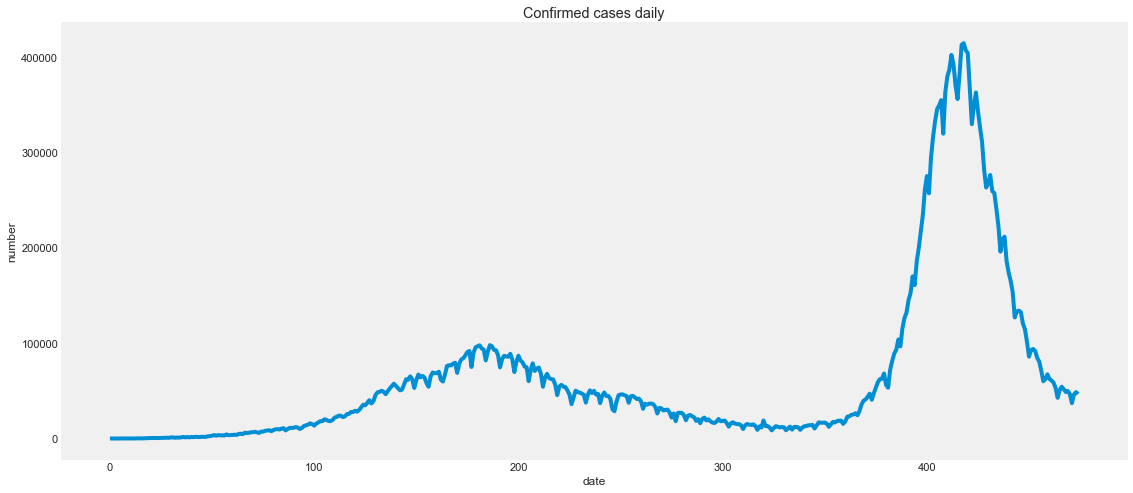

In [9]:
plt.figure(figsize=(17, 8))
plt.plot(data.Confirmed)
plt.title('Confirmed cases daily')
plt.ylabel('number')
plt.xlabel('date')
plt.grid(False)
plt.show()

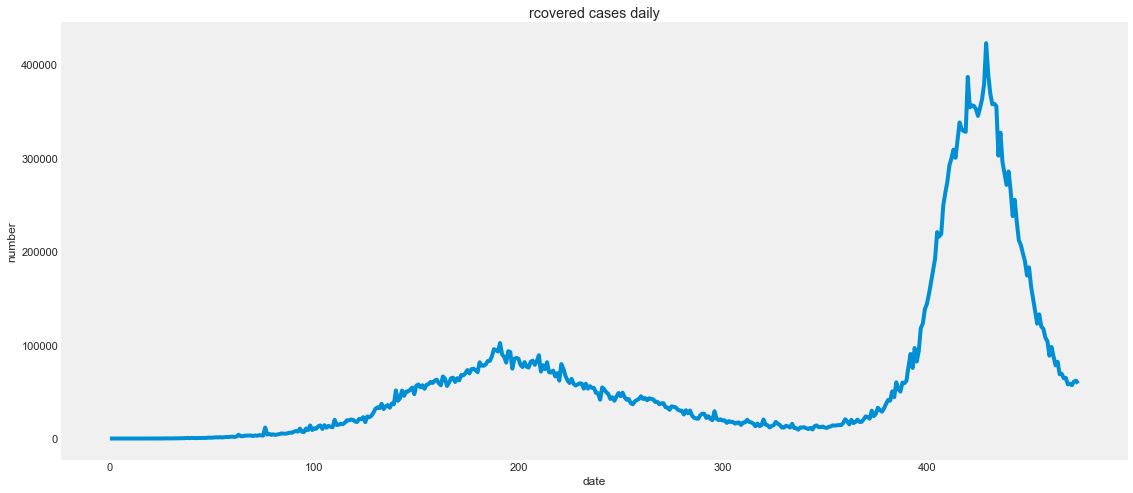

In [10]:
plt.figure(figsize=(17, 8))
plt.plot(data.Recovered)
plt.title('rcovered cases daily')
plt.ylabel('number')
plt.xlabel('date')
plt.grid(False)
plt.show()

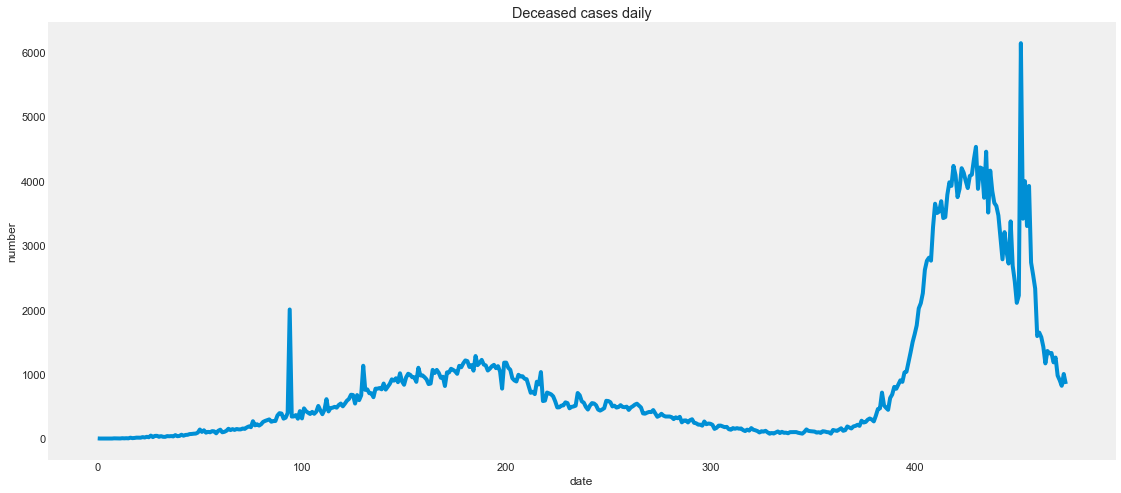

In [11]:
plt.figure(figsize=(17, 8))
plt.plot(data.Deceased)
plt.title('Deceased cases daily')
plt.ylabel('number')
plt.xlabel('date')
plt.grid(False)
plt.show()

### Moving average


In [12]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

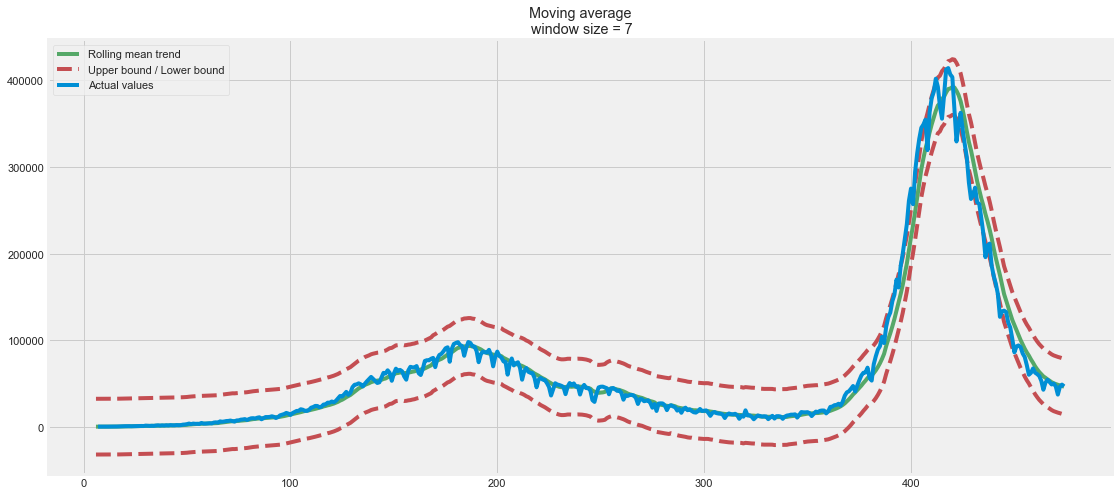

In [13]:
plot_moving_average(data.Confirmed,7,plot_intervals=True)

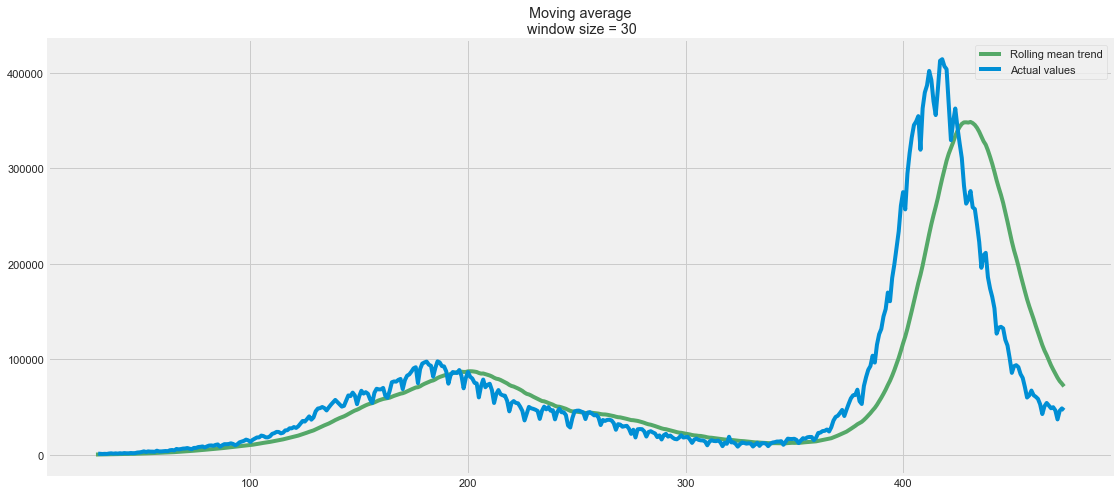

In [14]:
plot_moving_average(data.Confirmed,30)

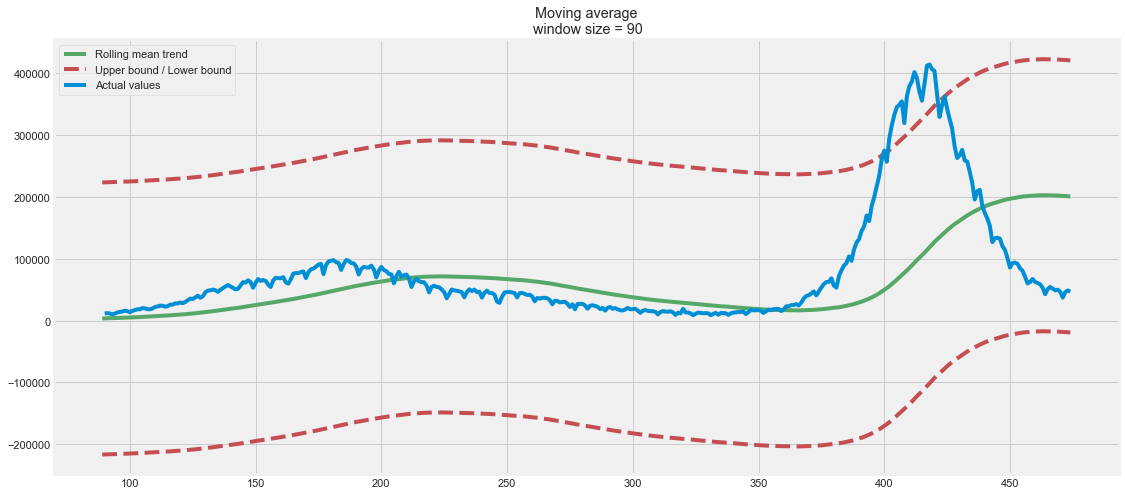

In [15]:
plot_moving_average(data.Confirmed, 90, plot_intervals=True)

### Exponential smoothing

In [48]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    print(result)
    return result

In [49]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

[81, 78.3, 75.13499999999999, 71.92824999999999, 70.18183749999999, 68.02274562499998, 67.52160834374999, 68.04552792656249, 67.99325153023435, 69.69358895372262, 69.4089095060365, 70.43846403073466, 70.16654082919793, 74.85821378773804, 78.26530309835114, 79.85203794343359, 85.2094360462619, 96.3989642439488, 112.77901603175135, 131.44006523016378, 152.86806196865558, 174.1746588702228, 195.91592592671168, 210.32012963037607, 228.45412314885726, 245.2814169914144, 273.66734614184367, 303.5339788347515, 331.0572798930139, 352.4044158983632, 396.93419510344506, 428.6374853482728, 451.5056110808591, 481.98033052681615, 503.9813140004753, 547.3322483004515, 598.9656358854289, 630.9673540911575, 676.2689863865996, 707.0555370672696, 755.0527602139061, 787.7001222032108, 840.0651160930502, 878.4118602883976, 912.8912672739777, 962.3467039102788, 999.4793687147649, 1039.6054002790265, 1107.4251302650753, 1180.2538737518214, 1268.8411800642302, 1388.1991210610186, 1467.3391650079675, 1574.072

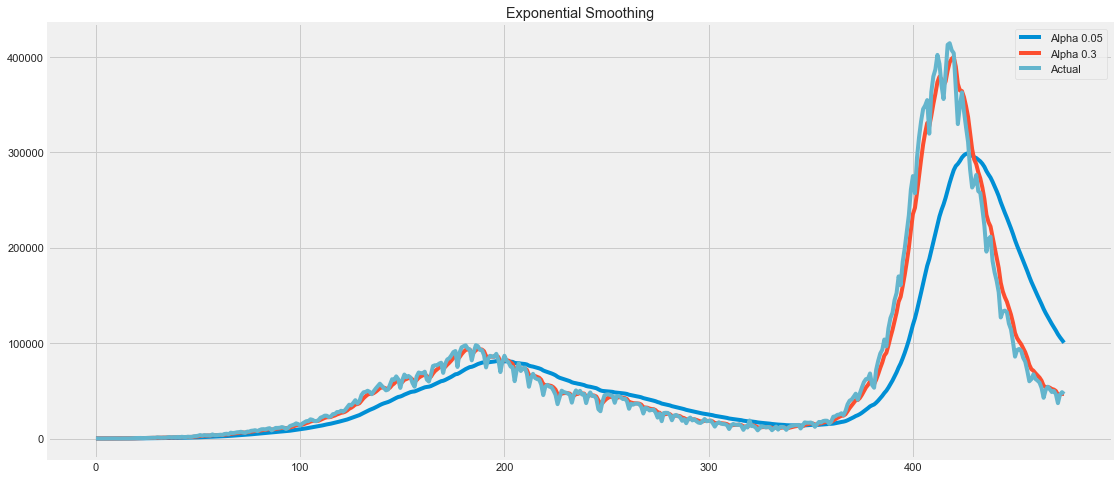

In [50]:
plot_exponential_smoothing(data.Confirmed, [0.05, 0.3])

### Double exponential smoothing 


In [19]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [20]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

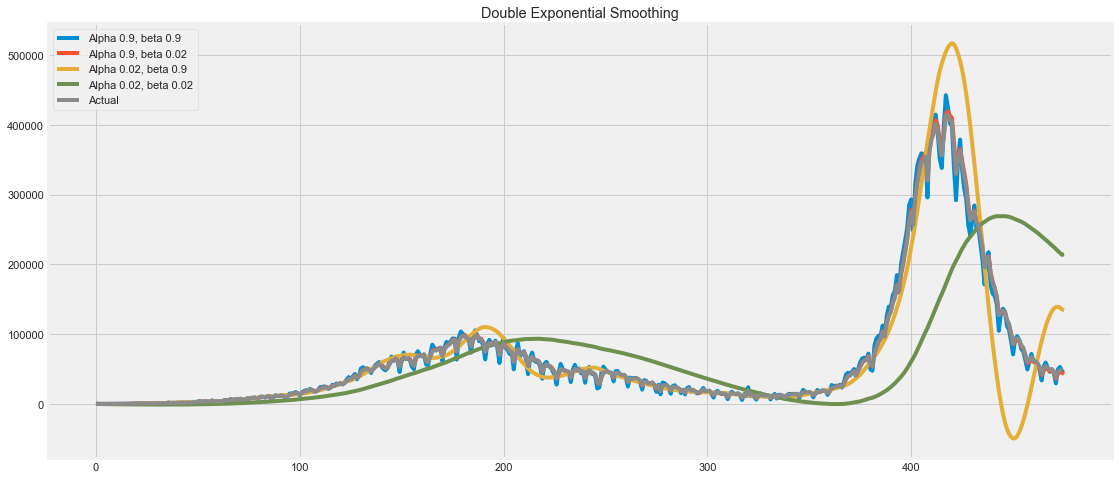

In [21]:
plot_double_exponential_smoothing(data.Confirmed, alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Stationarity 


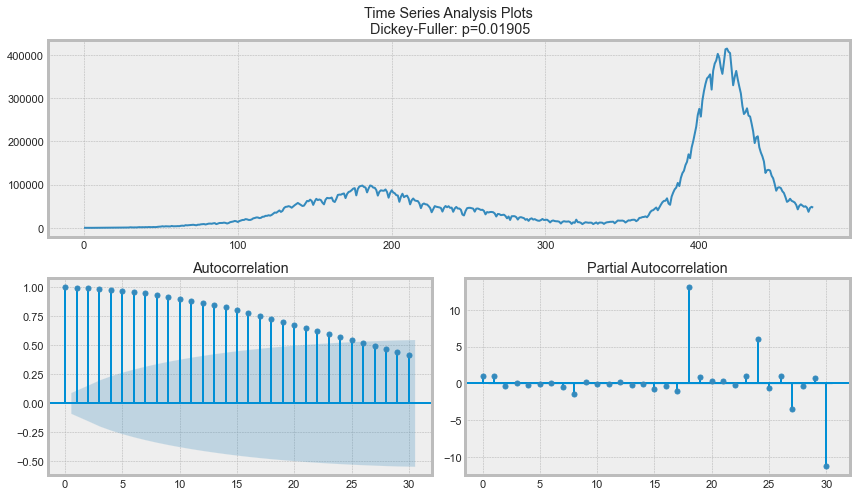

In [22]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.Confirmed, lags=30)

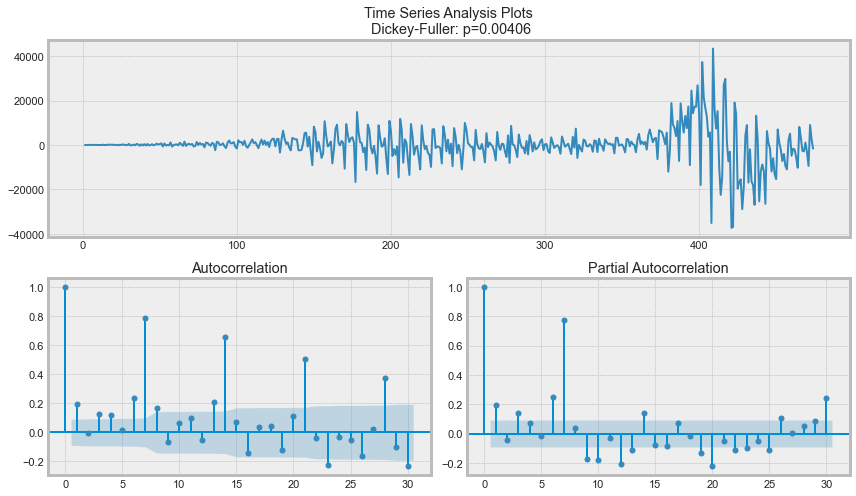

In [23]:
data_diff = data.Confirmed - data.Confirmed.shift(1)

tsplot(data_diff[1:], lags=30)

In [24]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=data.index, y=data["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=data.index, y=data["Deceased"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases in India",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [25]:
fig=px.bar(x=data.index,y=data["Confirmed"]-data["Recovered"]-data["Deceased"])
fig.update_layout(title="Distribution of Number of Active Cases in India",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

## FB Prophet

In [71]:
def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.85)
    train= ts[:size]
    test = ts[size:]
    return(train,test)
train,test=split(data)

In [72]:
data=data[data['Date']>='2021-05-01']
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 413 to 464
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       52 non-null     datetime64[ns]
 1   Confirmed  52 non-null     int64         
 2   Deceased   52 non-null     int64         
 3   Recovered  52 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 2.0 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 465 to 474
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10 non-null     datetime64[ns]
 1   Confirmed  10 non-null     int64         
 2   Deceased   10 non-null     int64         
 3   Recovered  10 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 400.0 bytes
None


In [73]:
df=train[['Date', 'Confirmed']]
df.columns=['ds' , 'y']

In [74]:
#importing fbprophet
from fbprophet import Prophet

#model
m = Prophet()

#fitting the model
m.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [75]:
future = m.make_future_dataframe(periods= 20) 
future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      72 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 704.0 bytes


In [76]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

ds          yhat    yhat_lower    yhat_upper
42 2021-06-12  84131.391880  71452.940682  97556.975545
43 2021-06-13  68297.363214  56890.477701  80590.426521
44 2021-06-14  51524.491118  38523.416512  63612.293311
45 2021-06-15  63881.676834  51986.962049  76249.905970
46 2021-06-16  76520.576418  64618.101488  88849.643354
47 2021-06-17  69682.170533  56924.748516  81059.993102
48 2021-06-18  64145.390160  52064.964146  76601.588469
49 2021-06-19  56730.951447  44364.307946  69331.770561
50 2021-06-20  40896.922781  29479.525356  53758.567251
51 2021-06-21  24124.050685  11852.441153  37200.344502
52 2021-06-22  36481.236401  23859.321068  48077.843612
53 2021-06-23  49120.135985  36015.331813  61725.767164
54 2021-06-24  42281.730100  29291.672042  54821.505598
55 2021-06-25  36744.949727  23995.716551  49455.682852
56 2021-06-26  29330.511014  16632.343698  42040.385286
57 2021-06-27  13496.482348   -408.540160  26163.890315
58 2021-06-28  -3276.389748 -17491.681451  10603.720623
59 2021-06-29   9080.795967  -5056.128019  22989.811213
60 2021-06-30  21719.695551   4815.847543  37270.334794
61 2021-07-01  14881.289667  -1673.847992  31716.946578
62 2021-07-02   9344.509294  -8370.443570  27661.779171
63 2021-07-03   1930.070580 -15636.460025  19290.332316
64 2021-07-04 -13903.958086 -32981.547866   6391.182114
65 2021-07-05 -30676.830182 -51366.408852  -9317.211355
66 2021-07-06 -18319.644466 -41223.413240   5210.987879
67 2021-07-07  -5680.744882 -31353.422071  19651.391782
68 2021-07-08 -12519.150766 -38894.790322  15901.429365
69 2021-07-09 -18055.931140 -47866.488821  13367.735124
70 2021-07-10 -25470.369853 -57520.569100   5954.324520
71 2021-07-11 -41304.398519 -72827.462853  -7790.229600

In [100]:
result = pd.DataFrame(columns = ['pred', 'actual'])

result['pred']=forecast['yhat']
result['actual']=data['Confirmed']
result2=data[data['Date']>='2021-05-01']
result

pred  actual
0   408736.080882     NaN
1   392345.133454     NaN
2   375015.342596     NaN
3   386815.609542     NaN
4   398897.590113     NaN
..            ...     ...
67   -5680.744882     NaN
68  -12519.150766     NaN
69  -18055.931140     NaN
70  -25470.369853     NaN
71  -41304.398519     NaN

[72 rows x 2 columns]

In [77]:
#fig1 = m.plot(forecast)
#fig2 = m.plot_components(forecast)
from fbprophet.plot import plot_plotly
fig = plot_plotly(m, forecast)  # This returns a plotly Figure
fig.update_layout(
                  autosize=False,
                  width= 750,
                  height= 800,
    title_text='<b>Covid-19 Total cases Forecast<b>',
    title_x=0.5,
    paper_bgcolor='khaki',
    plot_bgcolor = "khaki",)
fig.show()

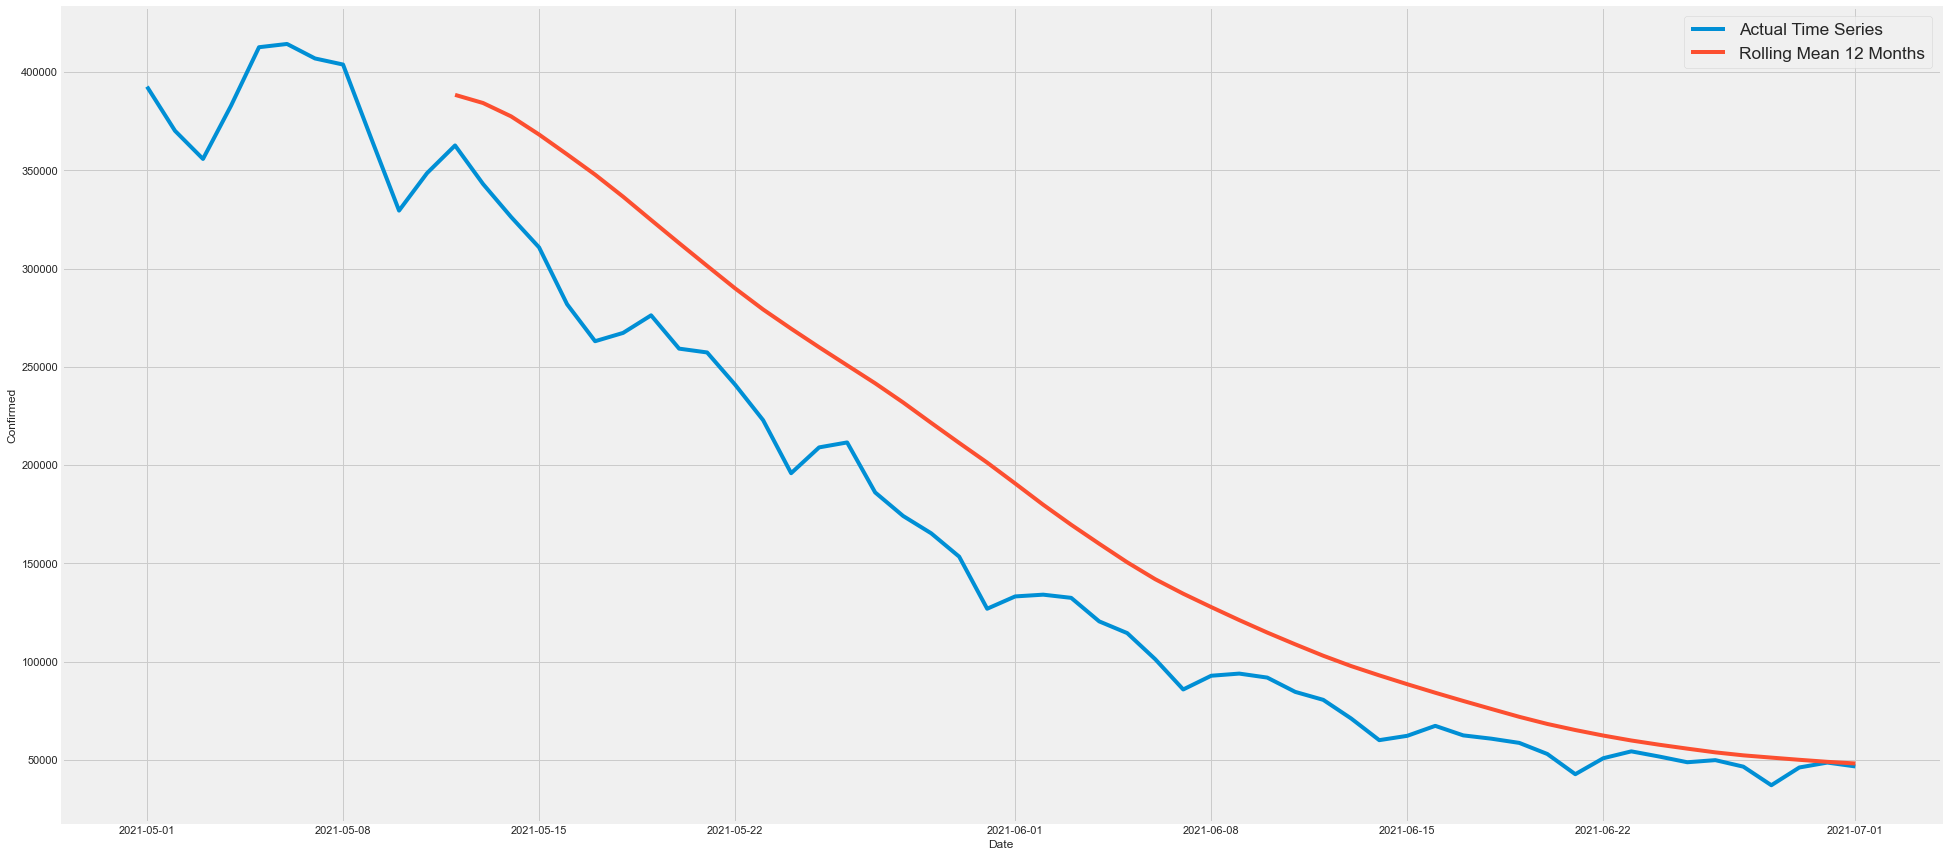

In [78]:
crossing = data[['Date', 'Confirmed']].groupby('Date').sum()

tseries = data.set_index('Date')

fig = plt.subplots(figsize=(30, 15))

g = sns.lineplot(x=tseries.index, y='Confirmed',
                 data=tseries, label="Actual Time Series")

rmean = crossing.rolling(12, win_type='triang').mean()

g = sns.lineplot(x=rmean.index, y='Confirmed',
                 data=rmean, label="Rolling Mean 12 Months")

plt.legend(fontsize='xx-large')
plt.show()


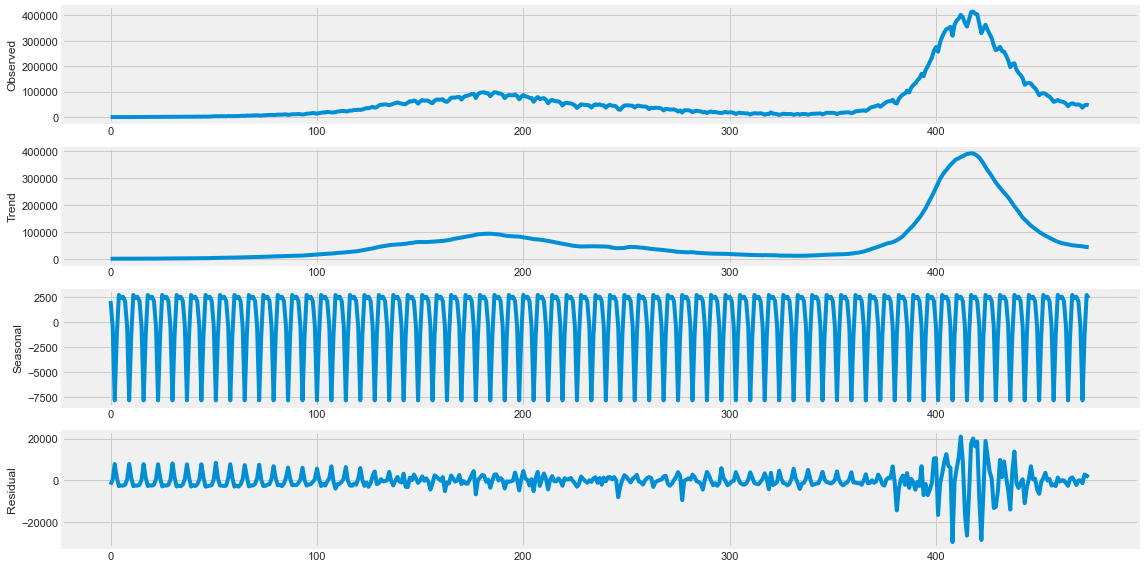

In [34]:

decompose = sm.tsa.seasonal_decompose(data.Confirmed, model='additive', extrapolate_trend='freq',freq=7)

# Plot.
fig, axes = plt.subplots(nrows=4, figsize=(16, 8))

decompose.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')

decompose.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decompose.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decompose.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')


plt.tight_layout()
plt.show()

In [35]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12)
                for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [38]:

mod = sm.tsa.statespace.SARIMAX(train.Confirmed,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Confirmed   No. Observations:                  403
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3792.207
Date:                            Tue, 06 Jul 2021   AIC                           7594.414
Time:                                    20:40:05   BIC                           7614.062
Sample:                                         0   HQIC                          7602.213
                                            - 403                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0408      0.010    102.874      0.000       1.021       1.061
ma.L1         -1.0263      0.020   

In [39]:
#Function to check the stationarity of the time serie using Dickey fuller test
def stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)

    
tsC=train['Confirmed'].values
stationarity(tsC)

Results of Dickey-Fuller Test:
Test Statistic                   0.088647
p-value                          0.965277
#Lags Used                      18.000000
Number of Observations Used    384.000000
Critical Value (1%)             -3.447495
Critical Value (5%)             -2.869096
Critical Value (10%)            -2.570795
dtype: float64


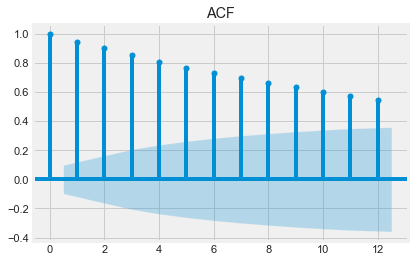

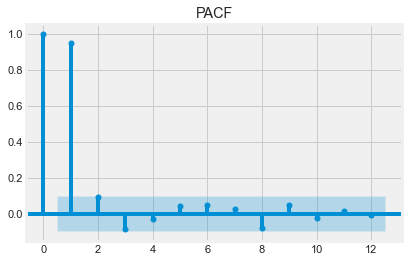

In [40]:
def corr(ts):
    plot_acf(ts,lags=12,title="ACF")
    plot_pacf(ts,lags=12,title="PACF")
    

#For China
corr(tsC)

In [ ]:
def create_features(df,label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['Date'] = df.index
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
   
    return X

                             ARIMA Model Results                              
Dep. Variable:           D2.Confirmed   No. Observations:                  401
Model:                 ARIMA(5, 2, 4)   Log Likelihood               -3849.699
Method:                       css-mle   S.D. of innovations           3540.683
Date:                Tue, 06 Jul 2021   AIC                           7721.397
Time:                        20:44:42   BIC                           7765.331
Sample:                             2   HQIC                          7738.794
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 40.1401     28.971      1.386      0.166     -16.641      96.922
ar.L1.D2.Confirmed     0.0173      0.054      0.318      0.750      -0.089       0.124
ar.L2.D2.Confirmed  

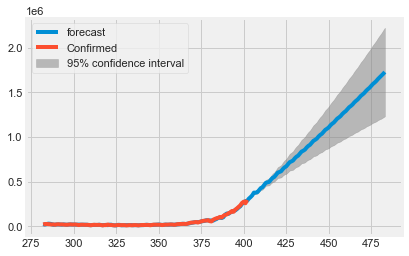

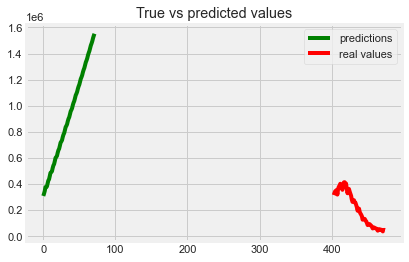

In [41]:
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.7), end=int(len(ts) * 1.2))
    pred=result.forecast(steps=len(test))[0]
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(pred,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('True vs predicted values')
    #Printing the error metrics
    print(result.summary())        
    
    print('\nMean absolute percentage error: %f'%mape(test,pred))

    return (pred)

pred=arima(train.Confirmed,test.Confirmed)


In [42]:
## Searching for paramaters
## Disabled for better looking

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,
                                                 param_seasonal, results.aic))
        except:
            continue

In [43]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12)
                for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [47]:
mod = sm.tsa.statespace.SARIMAX(train.Confirmed,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Confirmed   No. Observations:                  403
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3792.207
Date:                            Tue, 06 Jul 2021   AIC                           7594.414
Time:                                    20:47:35   BIC                           7614.062
Sample:                                         0   HQIC                          7602.213
                                            - 403                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0408      0.010    102.874      0.000       1.021       1.061
ma.L1         -1.0263      0.020   

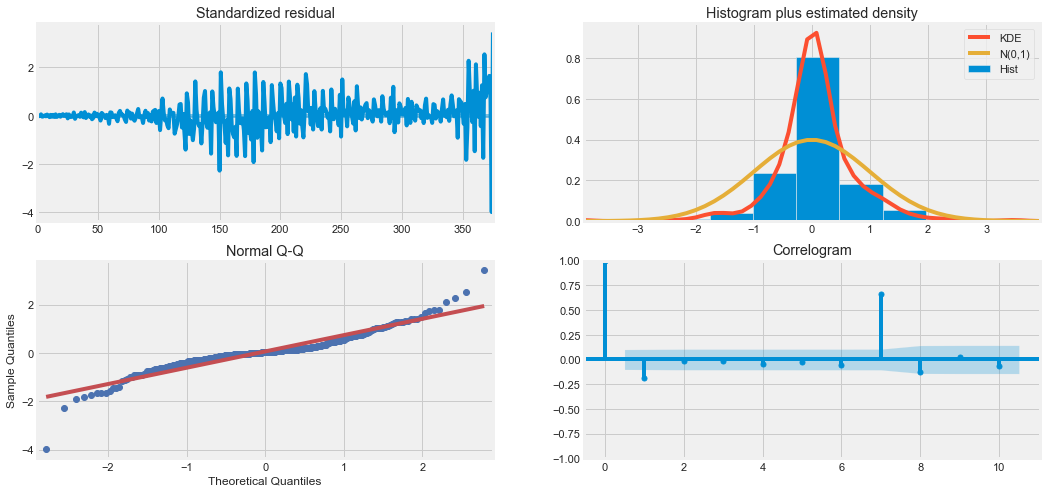

In [45]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [46]:
# Forecasting.

pred_uc = results.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()

ax = train.plot(label='Total Entries', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.15)

ax.set_xlabel('Date')
ax.set_ylabel('Total Entries')

plt.legend()
plt.show()

ValueError: Date ordinal 4721333.774086014 converts to 14896-07-27T18:34:41.031616 (using epoch 1970-01-01T00:00:00), but Matplotlib dates must be between year 0001 and 9999.

In [57]:

from numpy import loadtxt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [60]:
xgb = XGBRegressor(n_estimators=100)
xgb.fit(train.Confirmed,train.Recovered)
pred = xgb.predict(test.Confirmed)
xgb_forecast = xgb.predict(test.Recovered)
models.append('XGBoost')
mse.append(round(mean_squared_error(pred, y_test),2))
mae.append(round(mean_absolute_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))

IndexError: tuple index out of range

In [54]:
train

Status       Date  Confirmed  Deceased  Recovered
0      2020-03-14         81         2          9
1      2020-03-15         27         0          4
2      2020-03-16         15         0          1
3      2020-03-17         11         1          1
4      2020-03-18         37         0          0
..            ...        ...       ...        ...
398    2021-04-16     234002      1338     122886
399    2021-04-17     260895      1498     138209
400    2021-04-18     275063      1620     143839
401    2021-04-19     257003      1757     154357
402    2021-04-20     294365      2021     166656

[403 rows x 4 columns]

In [55]:
test


Status       Date  Confirmed  Deceased  Recovered
403    2021-04-21     315752      2101     179434
404    2021-04-22     332531      2257     192317
405    2021-04-23     345296      2620     220545
406    2021-04-24     348996      2761     215809
407    2021-04-25     354658      2808     218626
..            ...        ...       ...        ...
470    2021-06-27      46523       978      58563
471    2021-06-28      37070       907      57016
472    2021-06-29      46104       819      60789
473    2021-06-30      48606      1002      61813
474    2021-07-01      46636       847      58794

[72 rows x 4 columns]